(hypothesis-testing)=
# Bayesian Hypothesis Testing - an introduction

:::{post} December 2024
:tags: hypothesis testing, bayesian decision theory
:category: beginner 
:author: Benjamin T. Vincent
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
plt.rcParams.update({"font.size": 14, "figure.constrained_layout.use": False})
SEED = 42
rng = np.random.default_rng(SEED)

## Introduction

Bayesian hypothesis testing provides a flexible and intuitive way to assess whether parameters differ from specified values. Unlike classical methods focusing on p-values, Bayesian methods let us directly compute probabilities of hypotheses and quantify the strength of evidence in various ways.

In this tutorial, we'll use PyMC to:

* Fit a simple model to synthetic data and obtain samples from the prior and posterior distributions.
* Demonstrate the following Bayesian hypothesis testing methods:
  * Posterior probability statements
  * Highest Density Intervals (HDIs)
  * Regions of Practical Equivalence (ROPE)
  * Bayes Factors using ArviZ's `plot_bf` function

We'll work through a scenario where we want to know if the mean of some metric (e.g., monthly profit) is different from zero.

## Setting up the example

Rather than focus on a complex example, we'll pick a trivial one were we are simply estimating the mean of a single variable. This will allow us to focus on the hypothesis testing. The important thing is what we do with our MCMC samples, not the particulars of the model.

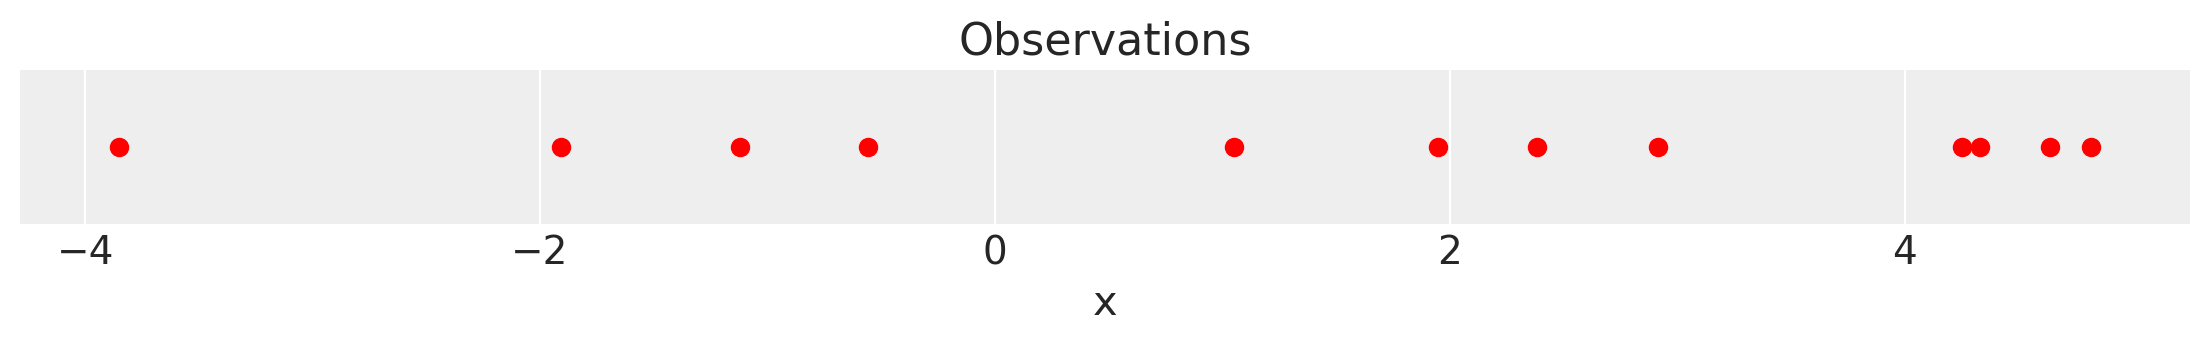

In [3]:
true_mu = 2.0
true_sigma = 3.0
n = 12

x = rng.normal(loc=true_mu, scale=true_sigma, size=n)

fig, ax = plt.subplots(figsize=(14, 1))
ax.plot(x, np.zeros_like(x), "ro")
ax.set(yticklabels=[], yticks=[], xlabel="x", title="Observations");

## Sampling from the prior and posterior

Now we'll build our simple model. Again, the focus here is not on the model of the data as such, but simply obtaining a meaningful prior and posterior distribution. We'll ask for more MCMC samples than we normally do, so that we can get a more accurate approximation of the prior and posterior distributions.

In [4]:
with pm.Model() as model:
    # priors
    mu = pm.Normal("mu", mu=0, sigma=2)
    sigma = pm.Gamma("sigma", alpha=2, beta=1)
    # likelihood
    pm.Normal("y", mu=mu, sigma=sigma, observed=x)
    # sample
    idata = pm.sample_prior_predictive(samples=10_000)
    idata.extend(pm.sample(draws=10_000))

Sampling: [mu, sigma, y]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


We didn't get any warnings from the sampling processes.

It is good practice to visualise the posterior distribution, so below we'll look at the joint posterior over $\mu$ and $\sigma$ parameters. Everything looks fine here.

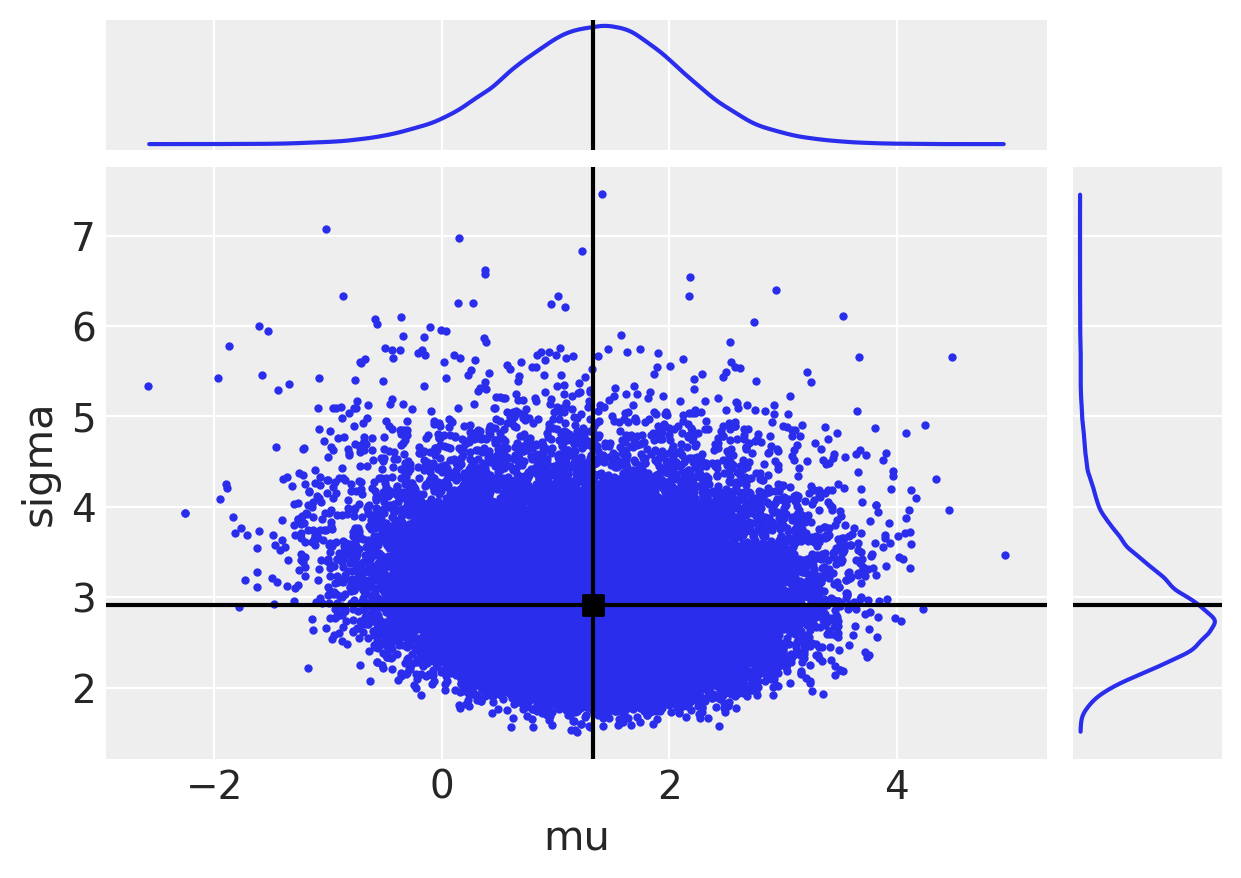

In [5]:
az.plot_pair(idata, var_names=["mu", "sigma"], marginals=True, point_estimate="mean");

Finally, seeing as $\mu$ is the core parameter of interest, we'll visualise both the prior and posterior distributions for $\mu$.

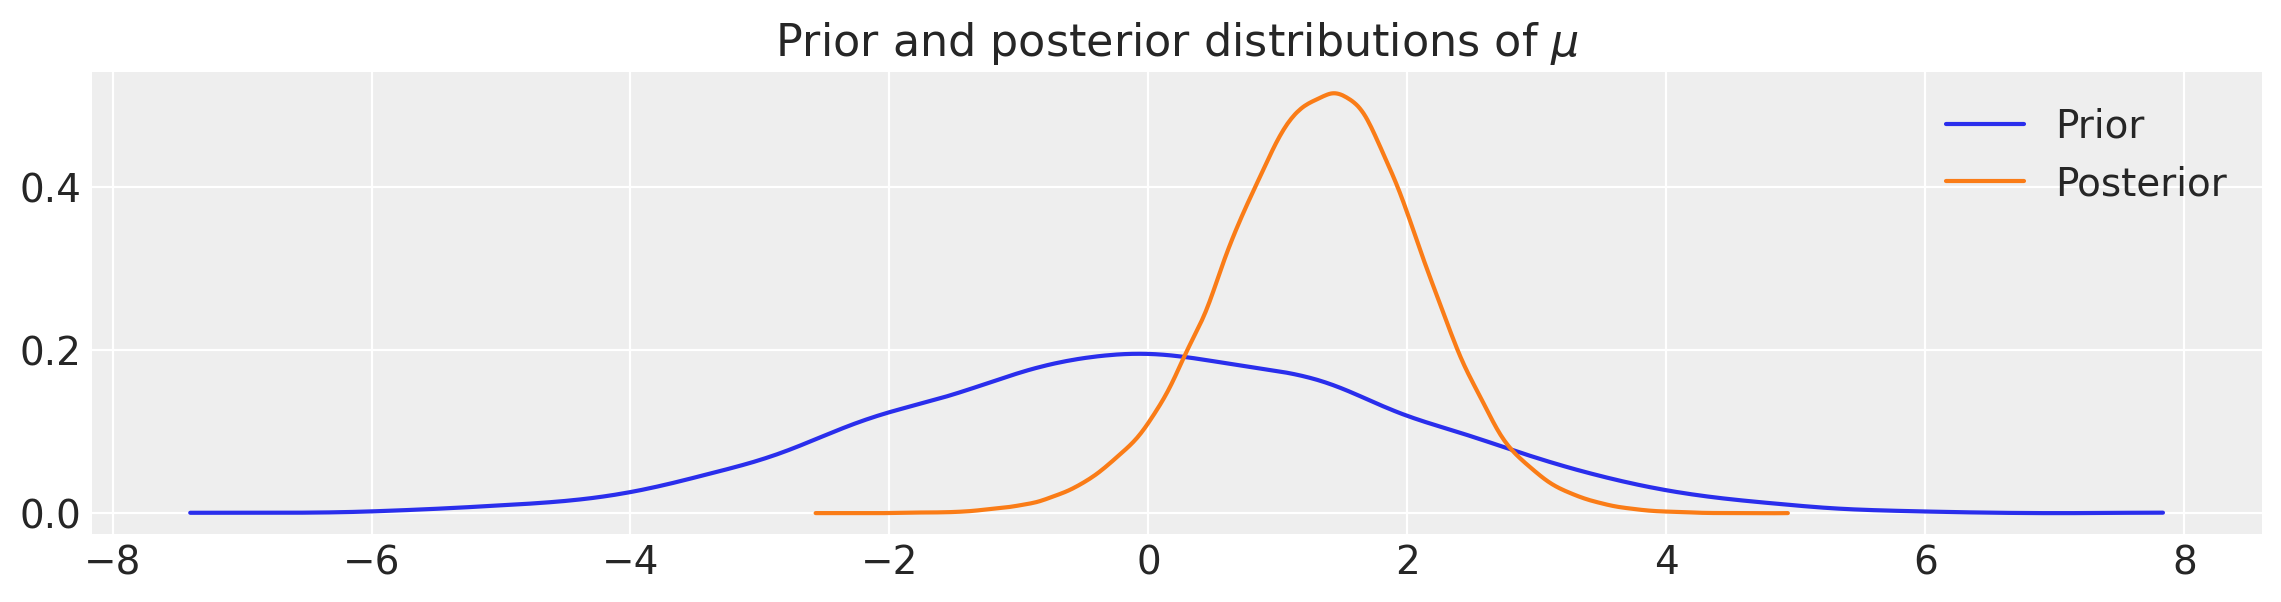

In [6]:
ax = az.plot_dist(idata.prior["mu"], label="Prior", color="C0", figsize=(14, 3))
az.plot_dist(idata.posterior["mu"], label="Posterior", color="C1", ax=ax)
ax.set(title=r"Prior and posterior distributions of $\mu$");

## Bayesian Hypothesis Testing Methods

### Posterior probability statements

The simplest form of hypothesis testing is to ask whether the mean is greater than zero. This is equivalent to asking whether the probability that $\mu$ is greater than zero is greater than 0.5. We can compute this directly from the samples. So computing compute $P(\mu>0 | x)$ is as simple as counting the number of samples where $\mu>0$ and dividing by the total number of samples - equivalent to computing the mean of the samples where $\mu>0$.

In [7]:
mu_samples = idata.posterior["mu"].values
p_mu_greater_0 = np.mean(mu_samples > 0)
p_mu_greater_0

0.951975

We can also include such information in a visual plot using `az.plot_posterior`.

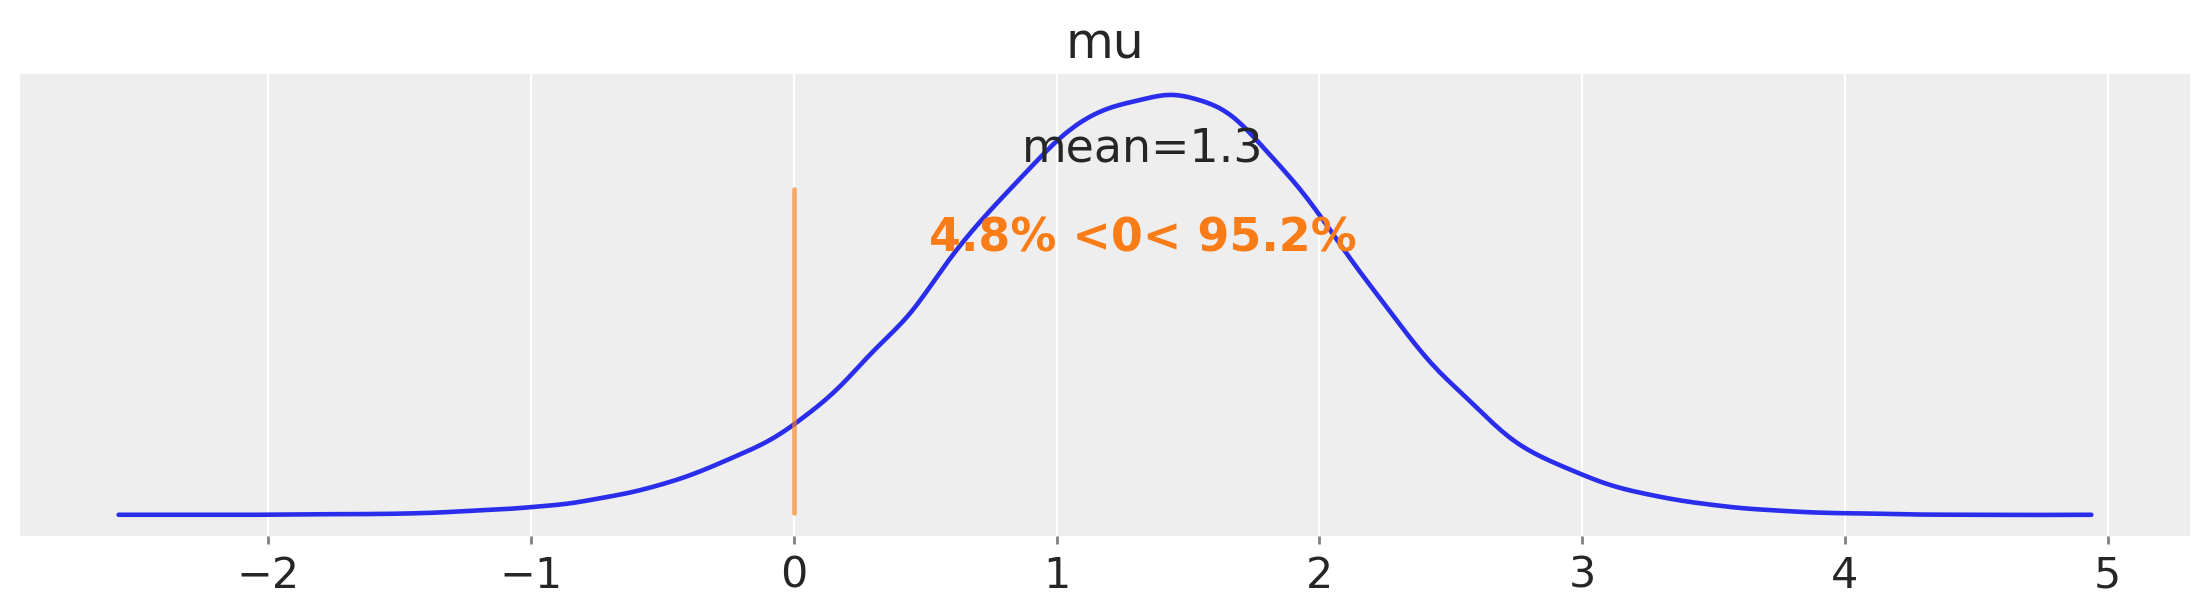

In [8]:
az.plot_posterior(idata, var_names=["mu"], ref_val=0, hdi_prob="hide", figsize=(14, 3));

It could also be that we have some kind of minimum meaningful threshold that we care about. For example, we might care about whether the mean is greater than 0.1. We can compute this in the same way.

In [9]:
p_mu_greater = np.mean(mu_samples > 0.1)
p_mu_greater

0.9394

### Highest Density Intervals (HDIs)

The HDI gives an interval of highest probability density. If zero is outside the HDI, it’s unlikely the parameter is near zero.

In [10]:
hdi_mu = az.hdi(idata, var_names=["mu"])["mu"].data
hdi_mu

array([-0.18592445,  2.79035127])

In this case, zero is within the HDI, so based on this measure, we can't express much confidence that the mean is different from zero.

Again, we can use `az.plot_posterior` to visualize the HDIs.

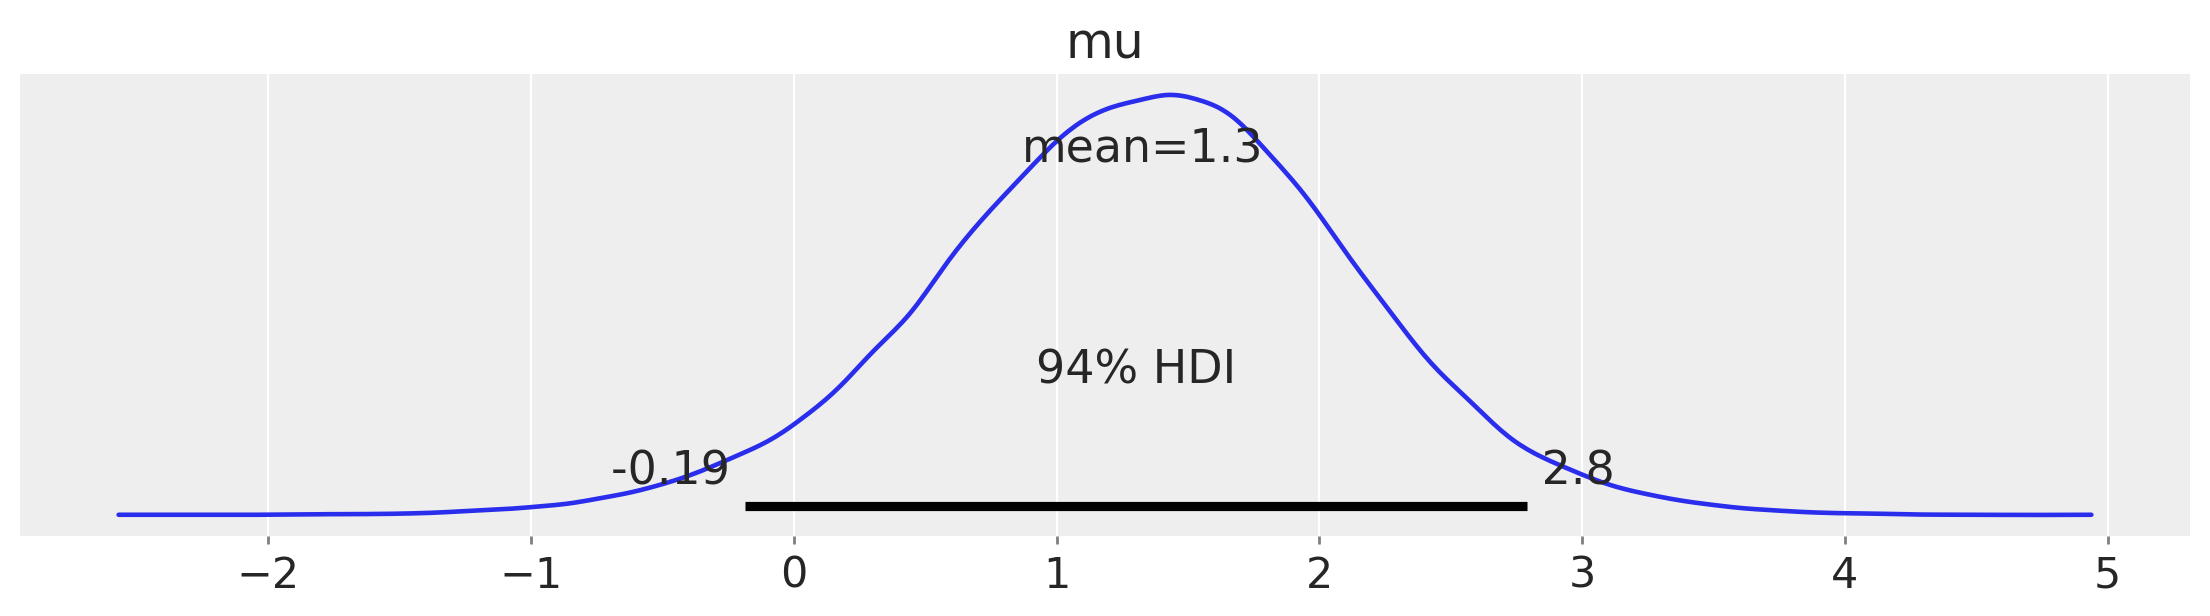

In [11]:
az.plot_posterior(idata, var_names=["mu"], figsize=(14, 3));

### Region of Practical Equivalence (ROPE)

If the probability that the parameter is within a certain range is high, we can say that the parameter is practically equivalent to that value. This is a useful way to express that we don't care about small differences. 

One proposal is that we now examine the HDI's but compare them to the ROPE and not zero.

In [12]:
rope = [-0.1, 0.1]
p_in_rope = np.mean((mu_samples > rope[0]) & (mu_samples < rope[1]))
p_in_rope

0.02225

Third time in a row, `arviz` has our back and can plot the ROPE and HDIs.

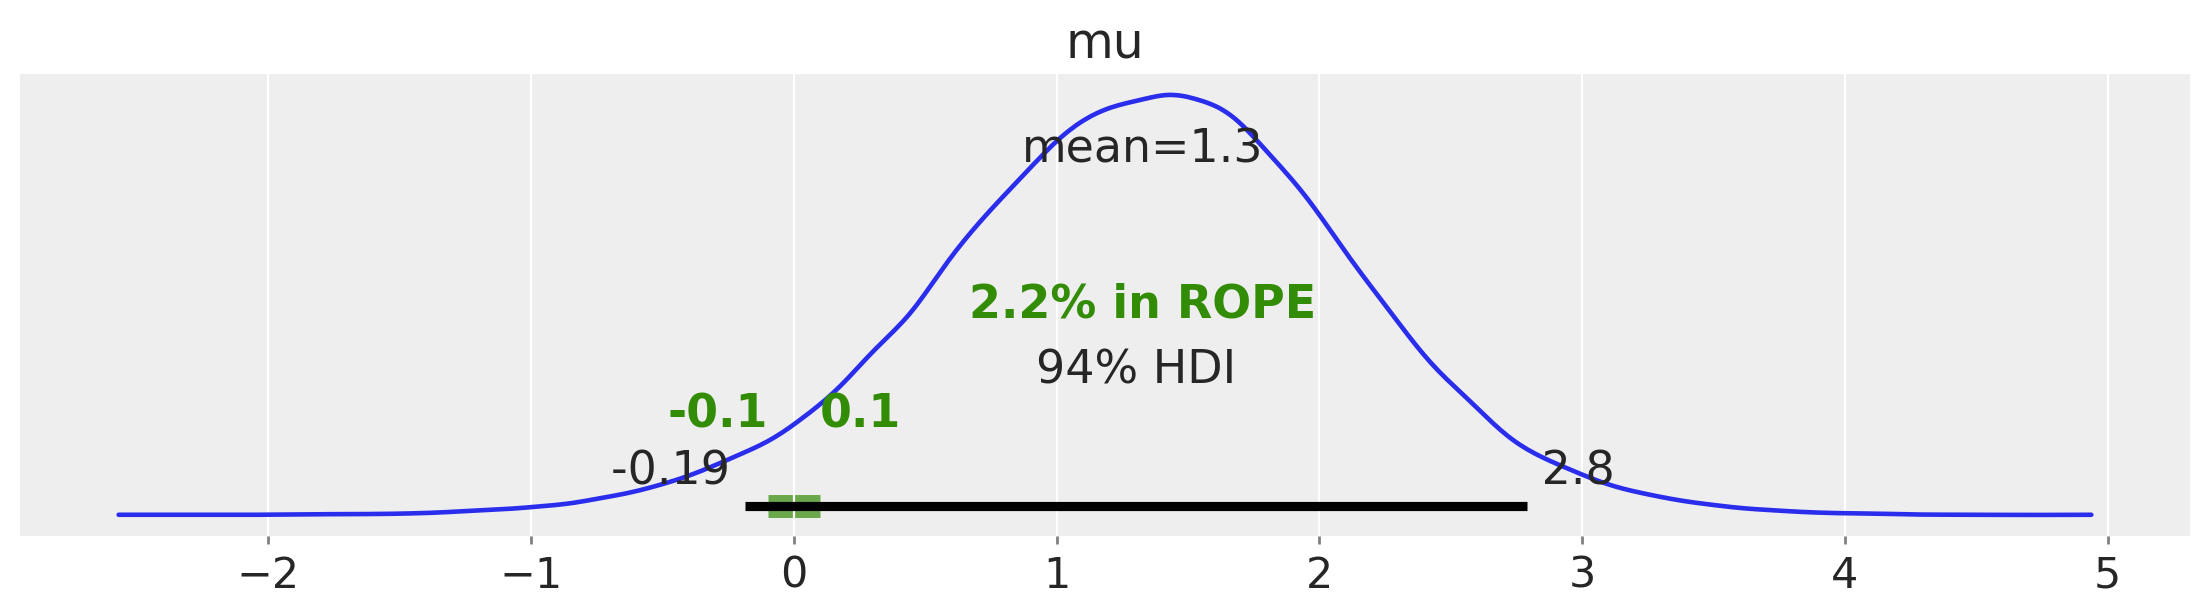

In [13]:
az.plot_posterior(idata, var_names=["mu"], rope=rope, figsize=(14, 3));

This shows that there is only a 2.6% chance that the mean is within the chosen ROPE.

{ref}`kruschke2018rejecting` outlines the HDI+ROPE decision rule, which is summarised in the figure taken from that paper:

![](hdi_plus_rope_decision_rule.png)

In our case, we would remain undecided because the HDI does not fall entirely outside nor within the ROPE.

### Bayes Factors

Bayes Factors provide a Bayesian alternative to classical hypothesis tests, allowing you to weigh evidence for one hypothesis relative to another. In the simplest case—testing whether $\mu=0$ versus $\mu \neq 0$ — the Bayes Factor (BF) tells you how much more (or less) likely your observed data are under the model where $\mu=0$ than under the model where $\mu$ is free to vary.

Intuitively, the Bayes Factor can be understood by comparing the density of $\mu$ at zero before and after observing the data. Before collecting data, you have a prior belief about $\mu$. This prior density at $\mu=0$ represents how plausible zero was considered initially. After seeing the data, you update these beliefs to get the posterior distribution. The posterior density at $\mu=0$ indicates how plausible zero remains given the evidence. The ratio of these densities—the Savage-Dickey ratio—is closely related to the Bayes Factor. If the data make 
$\mu=0$ more plausible relative to your initial belief, the Bayes Factor will favor  $\mu=0$. If the data diminish the credibility of $\mu=0$, the Bayes Factor will favor $\mu\neq0$

Because the Bayes Factor directly compares how the data update the prior odds of each hypothesis, the choice of prior is crucial. A strong prior concentration at $\mu=0$ could make it harder for data to move the posterior density away from zero, influencing the resulting Bayes Factor. On the other hand, a diffuse prior might make it easier for data to shift your beliefs about $\mu$. Thus, specifying a reasonable and justifiable prior distribution is essential when using Bayes Factors for hypothesis testing.

Yet again, `arviz` has a function to help us here. We can use `plot_bf` to compute the Bayes Factor for the hypothesis that $\mu=0$ versus $\mu\neq0$.

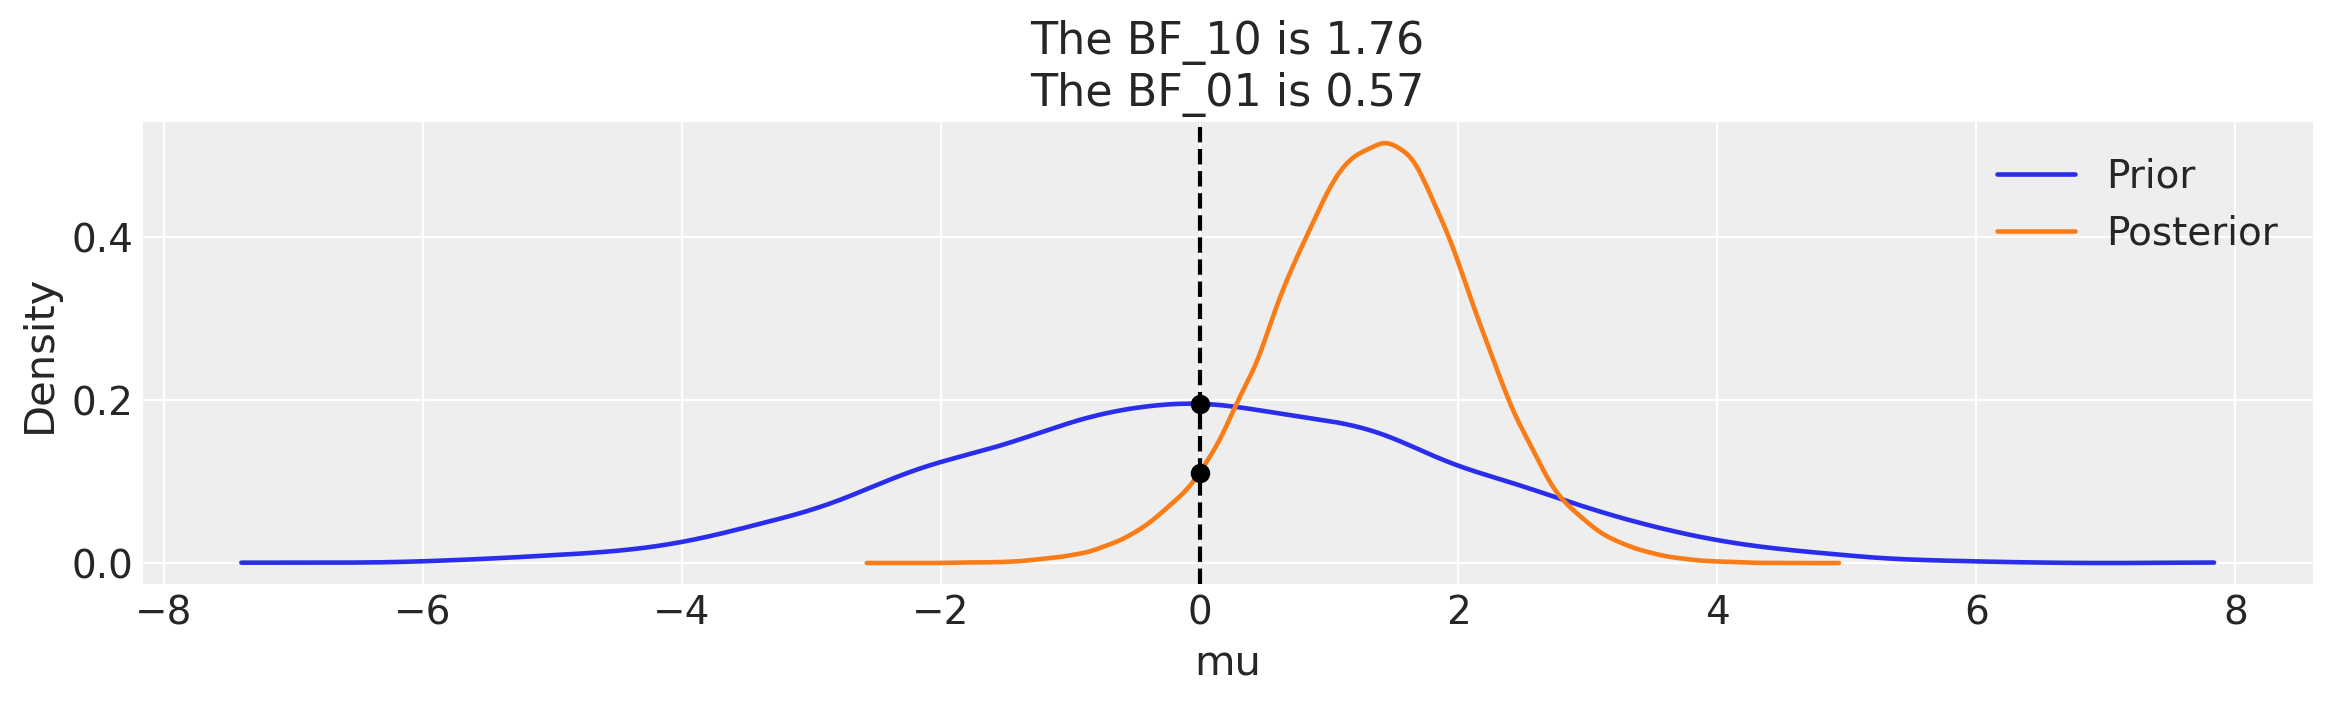

In [14]:
az.plot_bf(idata, var_name="mu", ref_val=0, figsize=(14, 3));

We can see that the probability of $\mu=0$ has gone _down_ after observing the data. This is reflected in the value of $BF_{01}=0.66$ in that it is less than 1.

## Summary

## Authors
* Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in December, 2024.

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Mon Dec 09 2024

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

pytensor: 2.26.4
xarray  : 2024.11.0

numpy     : 1.26.4
pymc      : 5.19.1
matplotlib: 3.9.3
arviz     : 0.20.0

Watermark: 2.5.0



:::{include} ../page_footer.md
:::